In [1]:
import pickle
import shutil

import numpy as np
import matplotlib.pyplot as plt

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

%load_ext autoreload
%autoreload 2

Optional mpi4py package is not installed.  MPI support is not available.


## Load pulsars and PTA object

In [2]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J1312+0051
J1909-3744
J1455-3330
B1953+29
J0709+0458


In [3]:
# load injected parameters
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
x_inj_dict = data_dict['x_inj'].item()

In [4]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_cw                            CWSignal                       10                  

params:
cw_costheta:Uniform(pmin=-1, pmax=1)                                                      
cw_phi:Uniform(pmin=0, pmax=6.283185307179586)                                            
cw_cosinc:Uniform(pmin=-1.0, pmax=1.0)                                                    
cw_log10_Mc:Uniform(pmin=6.0, pmax=10.0)                                                  
cw_log10_fgw:Unifo

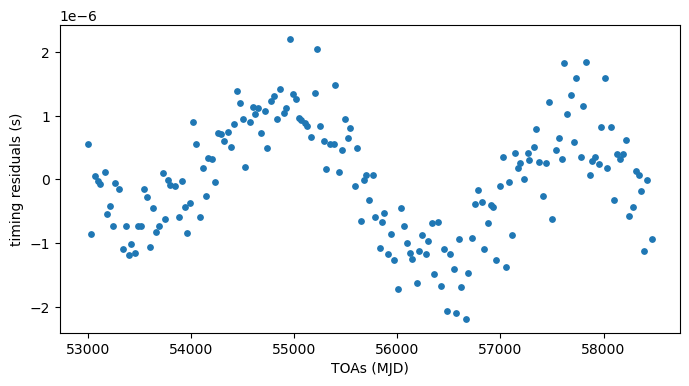

In [5]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [6]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [7]:
# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# prior function
def get_lnprior(params):
    return pta.get_lnprior(get_dict(params))

# posterior
def get_lnpost(params):
    return get_lnprior(params) + get_lnlike(params)

In [8]:
x_test = np.array([param.sample() for param in pta.params])
print(get_lnpost(x_test))

-3049.4496871099304


In [9]:
%timeit get_lnpost(x_test)

624 μs ± 6.69 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# store injected parameters in array
x_inj = []
for param_name in pta.param_names:
    print(f'{param_name} = {x_inj_dict[param_name]}')
    if param_name[-6:] == 'p_dist':  # pulsar distances are normalized
        x_inj.append(0.)
    else:
        x_inj.append(x_inj_dict[param_name])
x_inj = np.array(x_inj)

B1953+29_cw_p_dist = 5.39
B1953+29_cw_p_phase = 1.1356201445072323
J0709+0458_cw_p_dist = 1.0
J0709+0458_cw_p_phase = 1.6810792084862882
J1312+0051_cw_p_dist = 1.0
J1312+0051_cw_p_phase = 0.19841278879409074
J1455-3330_cw_p_dist = 0.74
J1455-3330_cw_p_phase = 2.1337351786484753
J1909-3744_cw_p_dist = 1.26
J1909-3744_cw_p_phase = 2.080150494542977
cw_cosinc = 6.123233995736766e-17
cw_costheta = 6.123233995736766e-17
cw_log10_Mc = 9.0
cw_log10_dL = -0.09691001300805639
cw_log10_fgw = -8.397940008672037
cw_phase0 = 3.141592653589793
cw_phi = 4.71238898038469
cw_psi = 1.5707963267948966


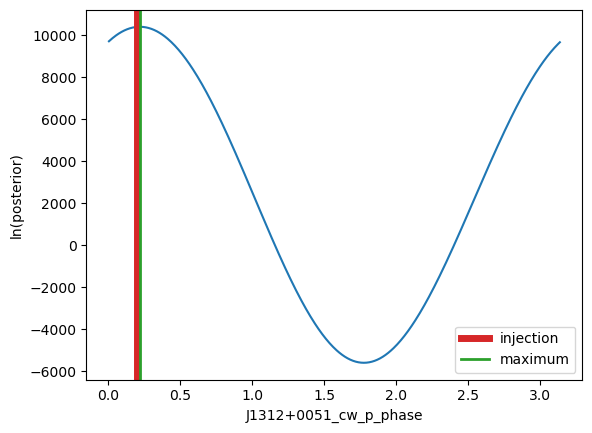

In [11]:
# plot cross-sections of posterior
param_ndx = 5
num_evals = 500
# get "minimum" and "maximum" of parameter values
param_samples = np.array([pta.params[param_ndx].sample() for _ in range(1000)])
param_vals = np.linspace(np.min(param_samples), np.max(param_samples), num_evals)
x_vals = np.tile(x_inj, (num_evals, 1))
x_vals[:, param_ndx] = param_vals
lnposts = np.array([get_lnpost(x) for x in x_vals])
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='C3', label='injection', lw=5)
plt.axvline(param_vals[np.argmax(lnposts)], color='C2', label='maximum', lw=2)
plt.legend()
plt.xlabel(pta.param_names[param_ndx])
plt.ylabel('ln(posterior)')
plt.show()

## MCMC

In [27]:
# set up the sampler:
ndim = len(x_inj)
cov = np.eye(ndim) * 0.001
outDir = 'enterprise_chains'

sampler = ptmcmc(ndim=ndim,
                 logl=get_lnlike,
                 logp=get_lnprior,
                 cov=cov, 
                 outDir=outDir,
                 resume=False)

# do MCMC
num_samples = int(2e6)
sampler.sample(p0=x_inj,
               Niter=num_samples,
               # SCAMweight=30,
               # AMweight=15,
               # DEweight=50,
               thin=1,
               )

# store chains in compressed binary format
print('Loading chains.')
chains = np.loadtxt('enterprise_chains/chain_1.txt', skiprows=int(0), usecols=(range(ndim + 1)))
ent_samples_dict = {name: val for name, val in zip(pta.param_names, chains[:,:-1].T)}
ent_samples_dict['lnposts'] = chains[:,-1]
# np.savez_compressed('ent_samples_dict.npz', **ent_samples_dict)
np.savez_compressed(
    'ent_samples_dict.npz',
    **{k: v[:] for k, v in ent_samples_dict.items()}
)
shutil.rmtree('enterprise_chains')
print('MCMC samples saved.')

Finished 0.00 percent in 0.000829 s Acceptance rate = 0

/opt/anaconda3/envs/PTA-x86/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.50 percent in 14.788117 s Acceptance rate = 0.575289Adding DE jump with weight 20
Finished 100.00 percent in 2449.056342 s Acceptance rate = 0.135738
Run Complete
Loading chains.
MCMC samples saved.


In [28]:
# np.savez_compressed(
#     'ent_samples_dict.npz',
#     **{k: v[int(2e5):] for k, v in ent_samples_dict.items()}
# )

## post-processing

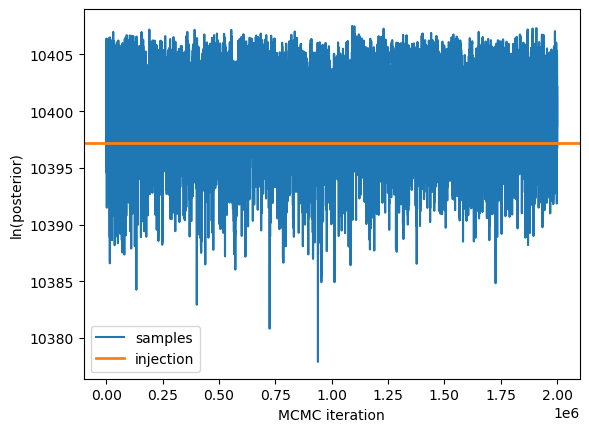

In [29]:
# plot posterior values of samples
plt.plot(ent_samples_dict['lnposts'], label='samples')
plt.axhline(get_lnpost(x_inj), color='C1', label='injection', lw=2)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.legend()
plt.show()

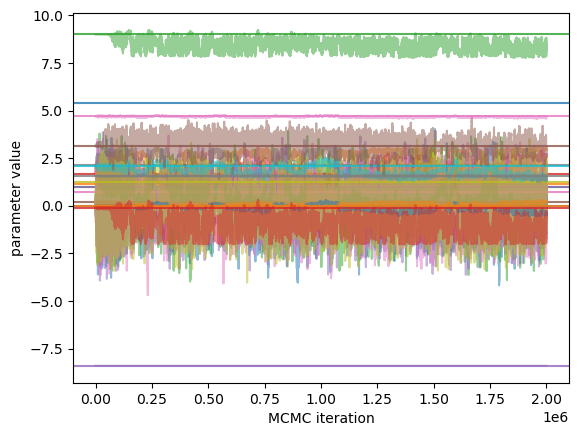

In [30]:
# make trace plot for parameters
for i, param_name in enumerate(pta.param_names):
    plt.plot(ent_samples_dict[param_name][:], color=f'C{i}', alpha=0.5)
    plt.axhline(x_inj_dict[param_name], color=f'C{i}',
                label=param_name, alpha=0.8)
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
# plt.legend()
plt.show()

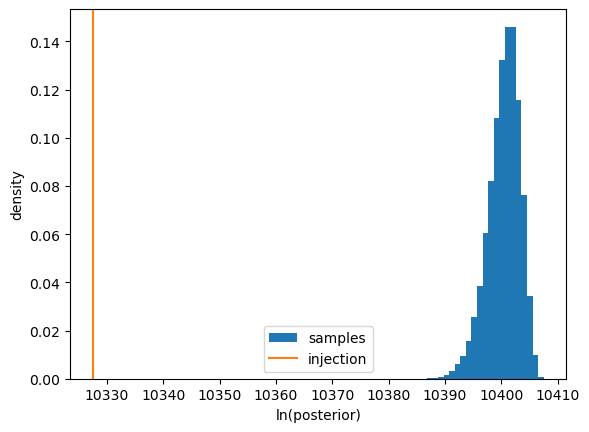

In [31]:
# histogram of posterior samples
plt.hist(ent_samples_dict['lnposts'], bins=30,
         label='samples', density=True)
plt.axvline(pta.get_lnlikelihood(x_inj_dict) + pta.get_lnprior(x_inj_dict),
            color='C1', label='injection')
plt.xlabel('ln(posterior)')
plt.ylabel('density')
plt.legend()
plt.show()

In [32]:
# # auto-correlation
# auto_corrs = [integrated_time(ent_samples_dict[name][50_000:])[0]
#               for name in pta.param_names]
# plt.bar(np.arange(len(pta.param_names)), auto_corrs)
# plt.ylabel('auto-correlation')
# plt.show()

In [33]:
ent_samples_dict['cw_phi']

array([4.71238898, 4.71238898, 4.71238898, ..., 4.65858713, 4.66113369,
       4.66234467])

(array([3.58000e+02, 2.77600e+03, 4.52780e+04, 2.40331e+05, 5.13462e+05,
        5.21014e+05, 3.68446e+05, 2.15713e+05, 8.23260e+04, 1.02970e+04]),
 array([4.55496377, 4.57682872, 4.59869367, 4.62055861, 4.64242356,
        4.6642885 , 4.68615345, 4.7080184 , 4.72988334, 4.75174829,
        4.77361324]),
 <BarContainer object of 10 artists>)

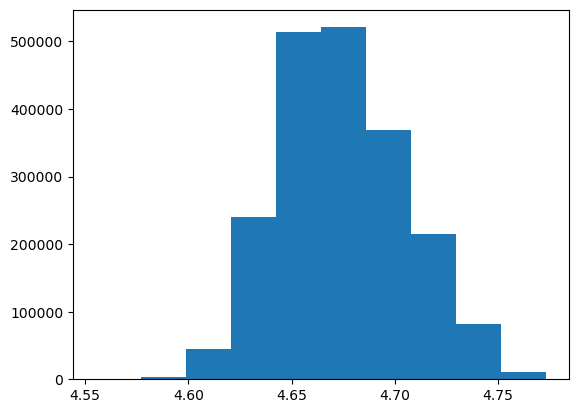

In [34]:
plt.hist(ent_samples_dict['cw_phi'])

Parameter cwlog10Mc in chain Enterprise is not constrained


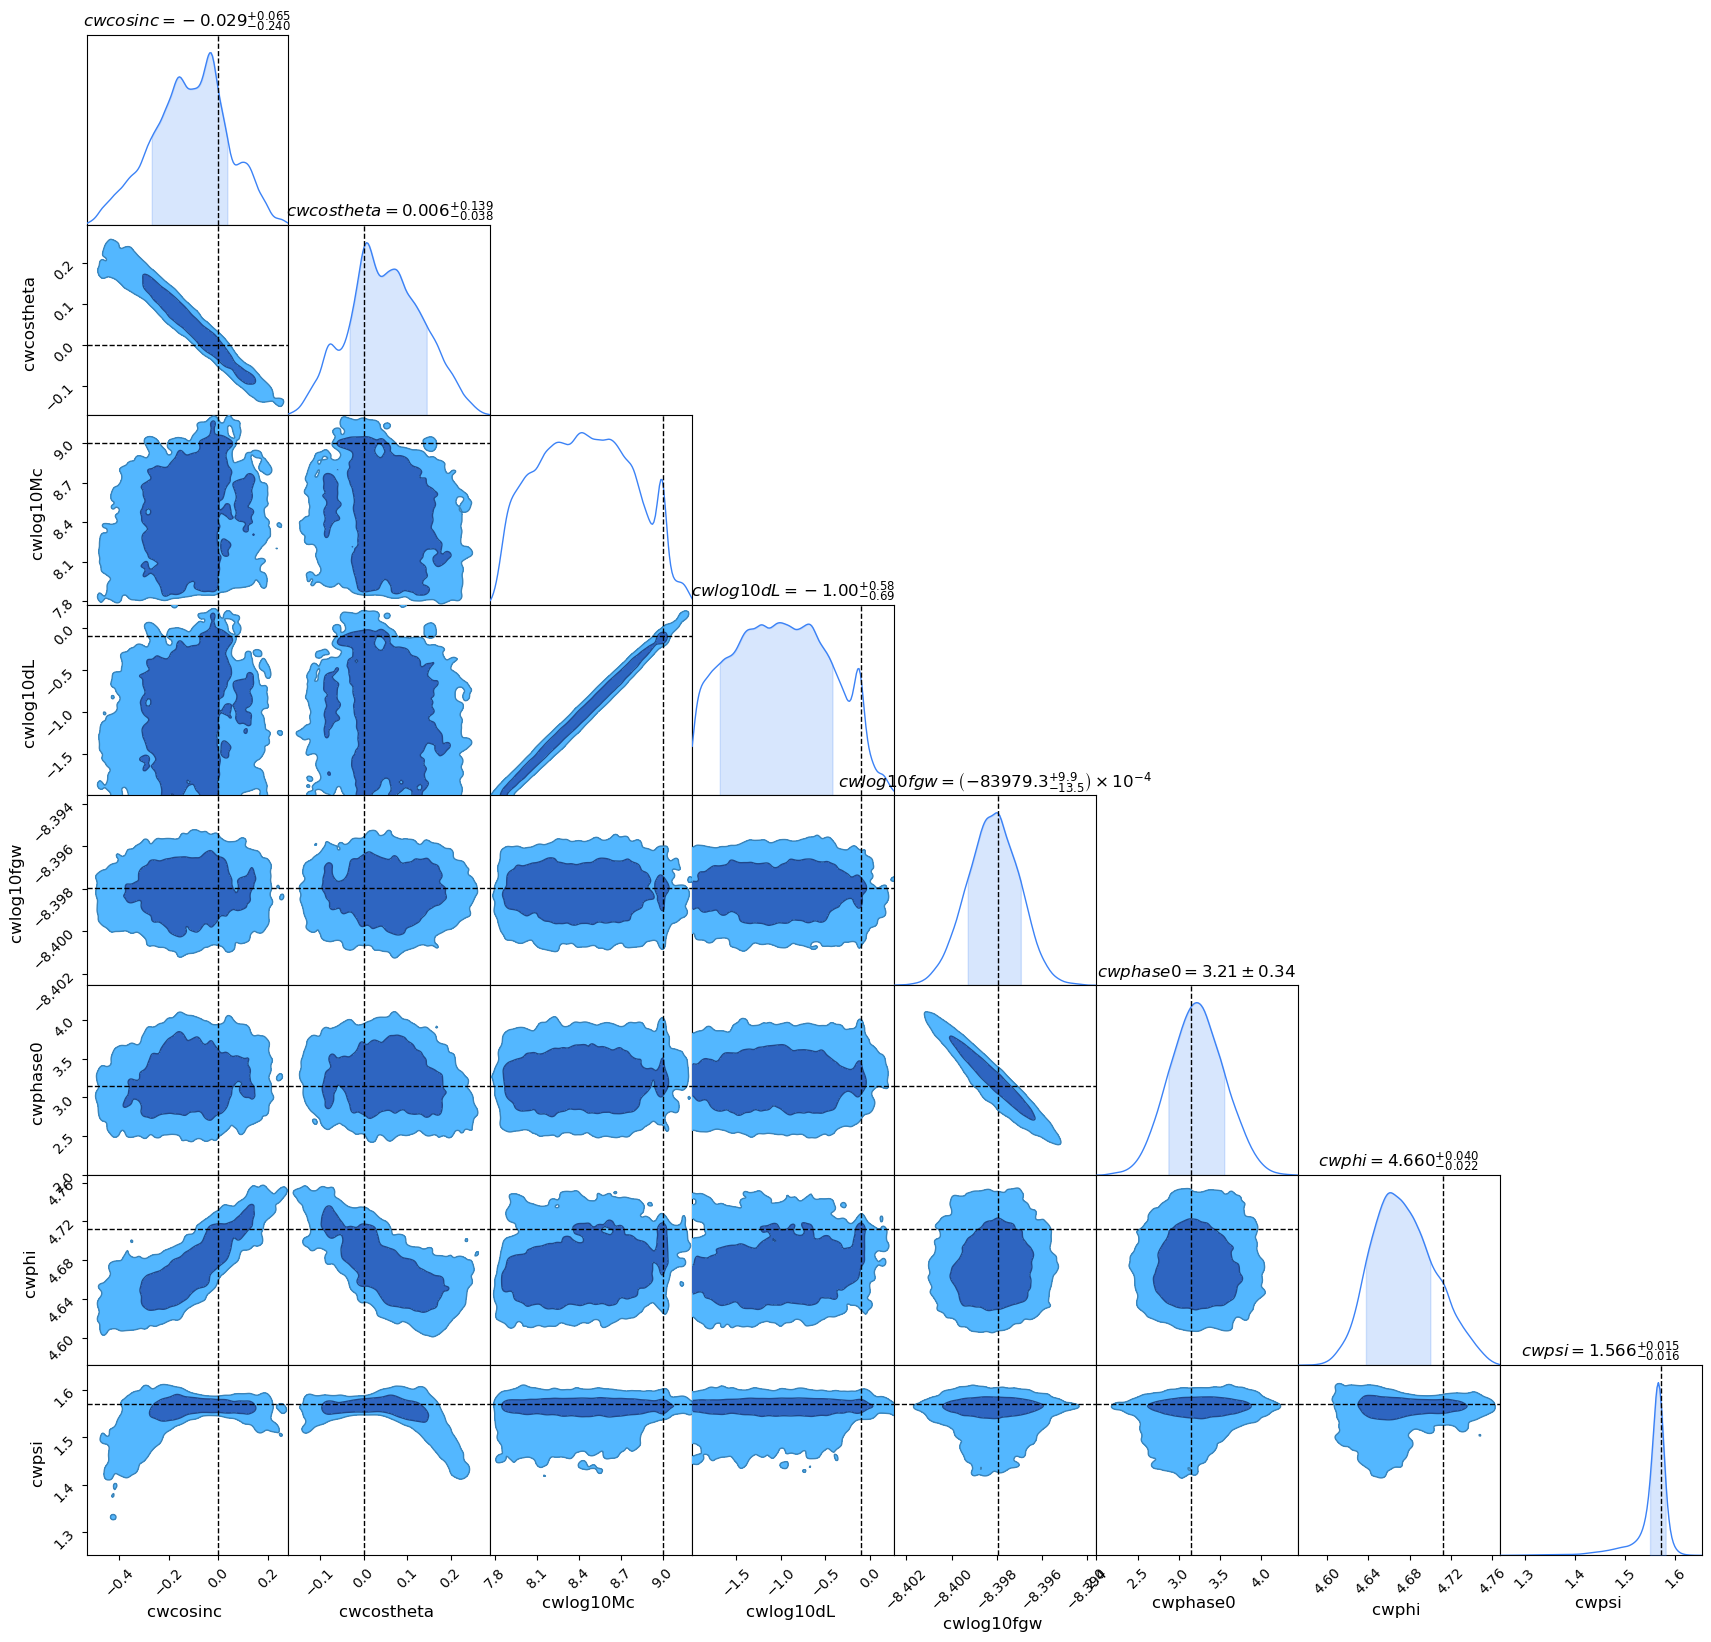

In [35]:
# corner plot
corner_ent_dict = {k.replace('_', ''): v for k, v in ent_samples_dict.items()}
corner_ent_truths = {k.replace('_', ''): v for k, v in x_inj_dict.items()}
ndxs = np.r_[10:18]
ent_df = pd.DataFrame(corner_ent_dict)
c = ChainConsumer()
c.add_chain(Chain(samples=ent_df.iloc[:, ndxs], name='Enterprise'))
c.add_truth(Truth(location=corner_ent_truths))
fig = c.plotter.plot()